# Monod demonstration: Noise decompositions 

In [20]:

import numpy as np
import copy

#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")



In [8]:
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [9]:
dataset_meta = ['A08', 'B01','B08','C01']
cluster_names = ['gaba','glu']
dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names] 
n_datasets = len(dataset_names)

In [10]:
dataset_names

['allen_A08_gaba',
 'allen_A08_glu',
 'allen_B01_gaba',
 'allen_B01_glu',
 'allen_B08_gaba',
 'allen_B08_glu',
 'allen_C01_gaba',
 'allen_C01_glu']

In [11]:
sr_strings = ['./fits/gg_220422_020_allen_celltypes_1/' +d + '/Bursty_Poisson_20x20/grid_scan_results_upd.res' for d in dataset_names]
sd_strings = ['./fits/gg_220422_020_allen_celltypes_1/' +d + '/raw.sd' for d in dataset_names]

In [12]:
sr_arr = []
sd_arr = []


for j in range(n_datasets):
    sd = load_search_data(sd_strings[j])
    sr = load_search_results(sr_strings[j])
    
    sd_arr.append(sd)
    sr_arr.append(sr)

INFO:root:Search data loaded from ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/raw.sd.
DEBUG:root:Grid scan results loaded from ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_20x20/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/raw.sd.
DEBUG:root:Grid scan results loaded from ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_20x20/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220422_020_allen_celltypes_1/allen_B01_gaba/raw.sd.
DEBUG:root:Grid scan results loaded from ./fits/gg_220422_020_allen_celltypes_1/allen_B01_gaba/Bursty_Poisson_20x20/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220422_020_allen_celltypes_1/allen_B01_glu/raw.sd.
DEBUG:root:Grid scan results loaded from ./fits/gg_220422_020_allen_celltypes_1/allen_B01_glu/Bursty_Poisson_20x20/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_2204

In [13]:
f_tech_naive = []
f_tech_mech = []

for j in range(n_datasets):
    f_tech_naive.append(sd_arr[j].get_noise_decomp()[:,1,1])
    d = sr_arr[j].get_noise_decomp()
    f_tech_mech.append(d[:,1,1]+d[:,0,1]) #combination of bursting and intrinsic noise
    
f_tech_naive = np.asarray(f_tech_naive)
f_tech_mech = np.asarray(f_tech_mech)

Text(0, 0.5, 'Density')

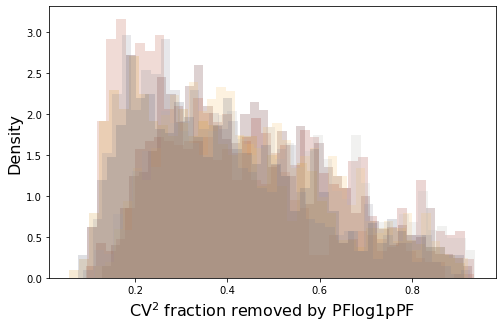

In [21]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.hist(f_tech_naive[j],nbin,alpha=0.2,density=True,facecolor=Demuth[j])
plt.xlabel(r'CV$^2$ fraction removed by PFlog1pPF',fontsize=fs)
plt.ylabel('Density',fontsize=fs)

Text(0, 0.5, 'Density')

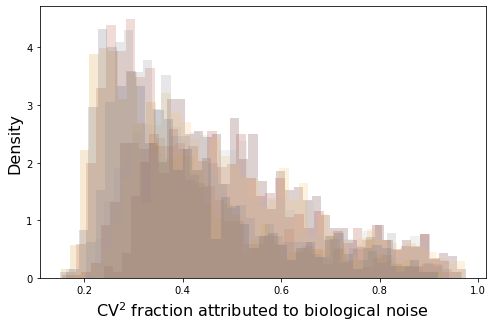

In [23]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.hist(f_tech_mech[j],nbin,alpha=0.2,density=True,facecolor=Demuth[j])
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.ylabel('Density',fontsize=fs)

INFO:root:Figure stored to /home/ggorin/projects/seq-cme-technoise/fits/gg_220422_020_allen_celltypes_1/analysis_figures/CV2_noise.png.


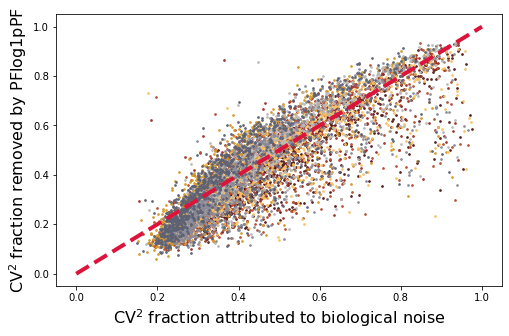

In [25]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.scatter(f_tech_mech[j],f_tech_naive[j],s=3,alpha=0.9,c=Demuth[j])
plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4)
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction removed by PFlog1pPF',fontsize=fs)

analysis_dir_string = '/home/ggorin/projects/seq-cme-technoise/fits/gg_220422_020_allen_celltypes_1/analysis_figures'
fig_string = analysis_dir_string+'/CV2_noise.png'

plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))
